In [1]:
ls \

ctrip.ipynb  product_info.txt  product_quantity.txt  submit.txt


In [2]:
#导入相关库
#导入相关库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime 
import sys
%matplotlib inline

In [3]:
#读取数据
evaluation=pd.read_csv('submit.txt')
product_info=pd.read_csv('product_info.txt')
product_quantity=pd.read_csv('product_quantity.txt')

In [4]:
#显示数据尺寸
print(evaluation.shape)
print(product_info.shape)
print(product_quantity.shape)

(56000, 3)
(4000, 22)
(1959676, 9)


In [5]:
evaluation.head(1)

,product_id,product_month,ciiquantity_month
0,1,2015-12-01,100


In [6]:
product_info.head(1)

,product_id,district_id1,district_id2,district_id3,district_id4,lat,lon,railway,airport,citycenter,...,citycenter2,eval,eval2,eval3,eval4,voters,startdate,upgradedate,cooperatedate,maxstock
0,1,10201,20502,31003,45760,3.994928,11.63463,-1.0,-1.0,-1.0,...,-1.0,3.0,5,2.0,3.1,1034.0,2005-11-01,2015-01-01,2013-07-02,75.0


In [7]:
product_quantity.head(1)

,product_id,product_date,orderattribute1,orderattribute2,orderattribute3,orderattribute4,ciiquantity,ordquantity,price
0,1,2014-06-21,2,1,1,1,0,1,-1


# 以上数据导入完成
# ————————————————————————————————————

In [8]:
train_day=pd.DataFrame({'product_id':product_quantity.product_id,'ciiquantity':product_quantity.ciiquantity,'product_date':product_quantity.product_date,})
train_day=train_day.sort_values(by =['product_id','product_date'])
train_day[0:1]

,ciiquantity,product_date,product_id
27,0,2014-01-01,1


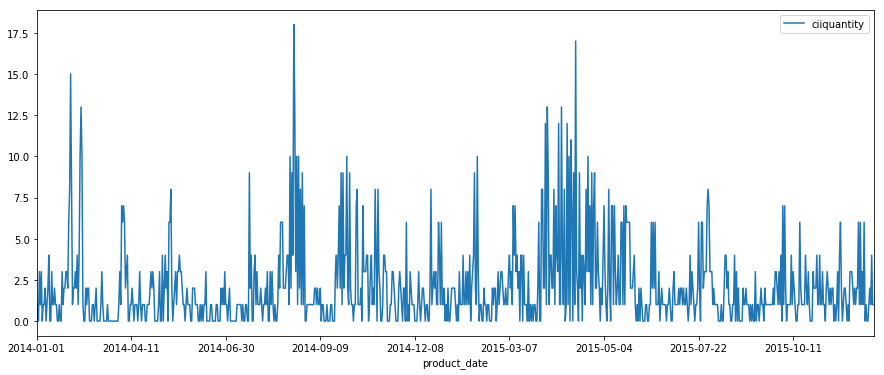

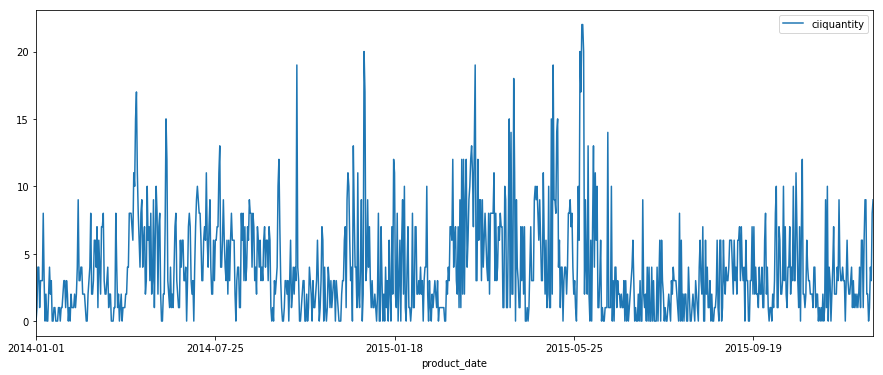

In [9]:
for i in range(2):
    train_day[train_day['product_id']==i+1].plot(x='product_date', y='ciiquantity',figsize=(15,6))

In [10]:
pd.options.mode.chained_assignment = None #禁止SettingWithCopyWarning 警告
Ttrain_day=train_day[800:900]
def getweek(product_date):
    yyyy=int(product_date[0:4])
    mm=int(product_date[5:7])
    dd=int(product_date[8:10])
    return datetime(yyyy,mm,dd).weekday()+1

def addweekday(table):
    table['week']=table['product_date'].apply(getweek)
    dummies = pd.get_dummies(table['week'], prefix='week', drop_first=False)
    table = pd.concat([table, dummies], axis=1)
    table = table.drop('week', axis=1)
    table = table.drop('product_date', axis=1)
    return table
Ttrain_day=addweekday(Ttrain_day)
Ttrain_day[0:1]

,ciiquantity,product_id,week_1,week_2,week_3,week_4,week_5,week_6,week_7
1335378,3,1,0,0,0,0,0,0,1


In [11]:
pd.options.mode.chained_assignment = None #禁止SettingWithCopyWarning 警告
Ttrain_day=train_day[800:900]
def getweek(product_date):
    yyyy=int(product_date[0:4])
    mm=int(product_date[5:7])
    dd=int(product_date[8:10])
    return datetime(yyyy,mm,dd).weekday()+1

def addweekday(table):
    table['week']=table['product_date'].apply(getweek)
    dummies = pd.get_dummies(table['week'], prefix='week', drop_first=False)
    table = pd.concat([table, dummies], axis=1)
    table = table.drop('week', axis=1)
    table = table.drop('product_date', axis=1)
    return table
Ttrain_day=addweekday(Ttrain_day)
Ttrain_day[0:1]

,ciiquantity,product_id,week_1,week_2,week_3,week_4,week_5,week_6,week_7
1335378,3,1,0,0,0,0,0,0,1


In [12]:
Ttrain_day=train_day[800:850]
Ttrain_day=train_day[885:887]
#Ttrain_day=train_day[900:1000]
Ttrain_day=addweekday(Ttrain_day)
features=['eval','eval2','eval3','eval4','voters','maxstock']
def addfeature(table,features):
    for feature in features:        
        table[feature]=table['product_id'].apply(lambda x: float(product_info[product_info.product_id==x][feature].as_matrix()[0]) )
    table=table.drop('product_id', axis=1)
    return table
Ttrain_day=addfeature(Ttrain_day,features)
Ttrain_day

,ciiquantity,week_1,week_3,eval,eval2,eval3,eval4,voters,maxstock
1335373,1,1,0,3.0,5.0,2.0,3.1,1034.0,75.0
466,0,0,1,3.0,4.0,2.0,3.4,1707.0,172.0


In [13]:
def Scalingfeature(table,features):
    for feature in features:
        mean, std = product_info[feature].mean(), product_info[feature].std()
        table.loc[:, feature] = (table[feature] - mean)/std
    return table
Ttrain_day=Scalingfeature(Ttrain_day,features)
Ttrain_day[0:1]

,ciiquantity,week_1,week_3,eval,eval2,eval3,eval4,voters,maxstock
1335373,1,1,0,-0.800491,0.261345,-0.712015,-0.830884,-0.266098,-0.529165


In [14]:
def cut_train_data(start,end):
    Mytrain_day=train_day[start:end]
    #Mytrain_day=train_day.take(np.random.permutation(len(train_day))[:k])
    features=['eval','eval2','eval3','eval4','voters','maxstock']
    Mytrain_day=addweekday(Mytrain_day)
    Mytrain_day=addfeature(Mytrain_day,features)
    Mytrain_day=Scalingfeature(Mytrain_day,features)
    features = Mytrain_day.drop('ciiquantity',axis=1)
    targets = Mytrain_day['ciiquantity']
    Myfeatures=features.as_matrix()
    Mytargets=targets.as_matrix()
    Mytargets.shape[0]
    Mytargets.shape = (Mytargets.shape[0], 1)
    Mytargets.transpose()
    return Myfeatures,Mytargets
tf_features,tf_targets = cut_train_data(0,1)
tf_features,tf_targets

(array([[ 1.        , -0.80049081,  0.26134466, -0.71201506, -0.83088377,
         -0.2660979 , -0.52916452]]), array([[0]]))

In [15]:
def random_cut_train_data(k):    
    Mytrain_day=train_day.take(np.random.permutation(len(train_day))[:k])
    features=['eval','eval2','eval3','eval4','voters','maxstock']
    Mytrain_day=addweekday(Mytrain_day)
    Mytrain_day=addfeature(Mytrain_day,features)
    Mytrain_day=Scalingfeature(Mytrain_day,features)
    features = Mytrain_day.drop('ciiquantity',axis=1)
    targets = Mytrain_day['ciiquantity']
    Myfeatures=features.as_matrix()
    Mytargets=targets.as_matrix()
    Mytargets.shape[0]
    Mytargets.shape = (Mytargets.shape[0], 1)
    Mytargets.transpose()
    return Myfeatures,Mytargets
start = datetime.now()
tf_features,tf_targets = random_cut_train_data(1)
end = datetime.now()
print(end-start)
tf_features,tf_targets

0:00:00.074477


(array([[ 1.        ,  1.16813092,  1.66926205,  1.24380161, -0.35105484,
          2.67668498,  0.87636409]]), array([[0]]))

In [20]:
def add_layer(inputs, in_size, out_size, activation_function=None):    
    Weights = tf.Variable(tf.random_normal([in_size, out_size]))
    biases = tf.Variable(tf.zeros([1, out_size]) + 0.1)
    Wx_plus_b = tf.matmul(inputs, Weights) + biases
    if activation_function is None:
        outputs = Wx_plus_b
    else:
        outputs = activation_function(Wx_plus_b)
    return outputs
in_shape=13
epochs=100
batch=1000
l_r=0.01
x = tf.placeholder(tf.float32, shape=[None, in_shape])
y = tf.placeholder(tf.float32, [None,1])
l1 = add_layer(x, in_shape, 7, activation_function=tf.nn.sigmoid)
prediction = add_layer(l1, 7, 1, activation_function=None)

loss = tf.reduce_mean(tf.reduce_sum(tf.square(y - prediction),
                     reduction_indices=[1]))
train_step = tf.train.GradientDescentOptimizer(l_r).minimize(loss)

In [21]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())    
    # Training cycle
for epoch in range(epochs):
    start = datetime.now()
    #tf_features,tf_targets = cut_train_data(epoch*1000,(epoch+1)*1000)
    tf_features,tf_targets = random_cut_train_data(batch)
    sess.run(train_step, feed_dict={x: tf_features, y: tf_targets})
    temploss = sess.run(loss, feed_dict={x: tf_features, y: tf_targets})
    end = datetime.now()
    sys.stdout.write('\rEpoch {:>2} Loss: {:.4f} time: {}'.format(epoch + 1,temploss,end-start))

Epoch 100 Loss: 82.9012 time: 0:00:04.731974

In [ ]:
import calendar
def get_evaluation(x):
    _date=evaluation[evaluation.index==x].product_month.as_matrix()[0]
    _id=evaluation[evaluation.index==x].product_id.as_matrix()[0]
    _yyyy=int(_date[0:4])
    _mm=int(_date[5:7])
    _days=calendar.monthrange(_yyyy,_mm)[1]
    _table=pd.DataFrame({'product_date':range(_days)})
    _table['product_date']=_table['product_date'].apply(lambda x:_date[0:8]+str(x+1).zfill(2))
    _table['product_id']=_id
    _features=['eval','eval2','eval3','eval4','voters','maxstock']
    _table=addweekday(_table)
    _table=addfeature(_table,_features)
    _table=Scalingfeature(_table,_features)
    _table=_table.as_matrix()
    return _table
y_array=np.sum(sess.run(prediction, feed_dict={x: get_evaluation(0)}))
print(y_array)
ciiquantity_month=np.zeros(evaluation.shape[0])
#'''
start = datetime.now()
for i in range(evaluation.shape[0]):
#for i in range(1000):    
    month_data=get_evaluation(i)
    month_data_sum=np.sum(sess.run(prediction, feed_dict={x: month_data}))
    ciiquantity_month[i]=month_data_sum
    if i % 100 == 0:
        end = datetime.now()        
        sys.stdout.write('\ri:{}/{} ciiquantity month:{} time:{}'.format(i+1,evaluation.shape[0],month_data_sum,end-start))
        start = datetime.now()
#'''
evaluation['ciiquantity_month']=ciiquantity_month

115.324
i:701/56000 ciiquantity month:157.3611602783203 time:0:00:16.413177

In [23]:
evaluation

,product_id,product_month,ciiquantity_month
0,1,2015-12-01,115.323700
1,2,2015-12-01,126.405785
2,3,2015-12-01,138.571869
3,4,2015-12-01,120.998116
4,5,2015-12-01,150.340668
5,6,2015-12-01,165.224808
6,7,2015-12-01,162.179916
7,8,2015-12-01,148.988098
8,9,2015-12-01,153.508804
9,10,2015-12-01,139.573227
